# Lezione 9

In [ ]:
from textwrap import dedent, indent

from liblet import (
    Grammar, 
    Derivation, 
    ProductionGraph, 
    show_calls
  )

## Eliminazione della ricorsione

In [ ]:
# grammatica per l'aritmetica col + e il - 

# versione ricorsiva

"""
E -> E + T | E - T | T
T -> t
""";

In [ ]:
# versione non ricorsiva

"""
E -> Eh Ets | Eh
Eh -> T
Ets -> Et Ets | Et
Et -> + T | - T
T -> t
""";

Per ragioni che saranno chiarite in seguito, imponiamo una restrizione sulla grammatica. 

Diremo che un non terminale $A\in N$ è *prefix-free* se solo se per ogni $x, y
\in T^+$ non accada che $A\stackrel{*}{\to} xy$ e $A\stackrel{*}{\to} x$ (ossia
$A$ non deriva mai sia una parola che un suo prefisso). Una grammatica è
*prefix-free* se e solo se tutti i suoi non terminali sono prefix-free.

Per inciso, un linguaggio $L$ è *prefix-free* se e solo se per ogni stringhe $x, y\in T^+$ si ha che $x\in L$ implica $xy\not\in L$;  mentre è ovvio che una grammatica prefix-free genera un linguaggio prefix-free, non è vero il viceversa.

Detto altrimenti, un linguaggio prefix-free può essere generato da una grammatica non prefix-free. Si consideri ad esempio il linguaggio finito generato da

```
S -> T #
T -> a | ab
```

che è evidentemente prefix-free, come è altrettanto evidente che `T` non sia prefix-free.

In [ ]:
# versione prefix-free

G = Grammar.from_string("""
E -> Eh Ets | Eh #
Eh -> T
Ets -> Et Ets | Et #
Et -> + T | - T
T -> t
""")
G

Grammar(N={E, Eh, Et, Ets, T}, T={#, +, -, t}, P=(E -> Eh Ets, E -> Eh #, Eh -> T, Ets -> Et Ets, Ets -> Et #, Et -> + T, Et -> - T, T -> t), S=E)

Tale grammatica è prefix-free dato che:

* `Eh`, `T` ed `Et` generano linguaggi finiti quindi è elementare convincersi
  che sono prefix-free;
* `Ets` genera parole che non contengono `#` ma terminano con tale simbolo,
  risultando pertanto prefix-free; 
* similmente `E` genera `t#` oppure le stesse parole generate da `Ets` per cui
  risulta anchesso prefix-free.

## Costruzione manuale del parser

Costruiamo una funzione `parse` (a partire dalla grammatica $G$) che su input $X$ e $\alpha\beta$ restituisce una coppia $(b, \beta)$ dove $b$ è `True` se e solo se il simbolo $X \in N \cup T$ è tale che $X\stackrel{*}{\to}\alpha$.

In [ ]:
@show_calls(True)
def parse(X, rest):

  if X in G.T:

    if rest and rest[0] == X: return True, rest[1:]

  elif X == 'T': # T -> t

    return parse('t', rest)

  elif X == 'Eh': # Eh -> T

    return parse('T', rest)

  elif X == 'Et': # Et -> + T | - T

    s, r = parse('+', rest)
    if s: return parse('T', r)
    s, r = parse('-', rest)
    if s: return parse('T', r)

  elif X == 'Ets': # Ets -> Et Ets | Et #

    s0, r0 = parse('Et', rest)
    if s0:
      s1, r1 = parse('#', r0)
      if s1: return True, r1
      return parse('Ets', r0)
  
  elif X == 'E': # E -> Eh Ets | Eh #

    s0, r0 = parse('Eh', rest)
    if s0:
      s1, r1 = parse('#', r0)
      if s1: return True, r1
      return parse('Ets', r0)

  return False, rest

Decidere se $\omega\in L(G)$ equivale a chiedersi se su input $E$ e $\omega$ la funzione restituisce (`True`, $\varepsilon$).

In [ ]:
INPUT = list('t+t-t#') # le parole sono liste di stringhe…

parse('E', INPUT)

┌parse('E', ['t', '+', 't', '-', 't', '#'])
│┌parse('Eh', ['t', '+', 't', '-', 't', '#'])
││┌parse('T', ['t', '+', 't', '-', 't', '#'])
│││┌parse('t', ['t', '+', 't', '-', 't', '#'])
│││└─ (True, ['+', 't', '-', 't', '#'])
││└─ (True, ['+', 't', '-', 't', '#'])
│└─ (True, ['+', 't', '-', 't', '#'])
│┌parse('#', ['+', 't', '-', 't', '#'])
│└─ (False, ['+', 't', '-', 't', '#'])
│┌parse('Ets', ['+', 't', '-', 't', '#'])
││┌parse('Et', ['+', 't', '-', 't', '#'])
│││┌parse('+', ['+', 't', '-', 't', '#'])
│││└─ (True, ['t', '-', 't', '#'])
│││┌parse('T', ['t', '-', 't', '#'])
││││┌parse('t', ['t', '-', 't', '#'])
││││└─ (True, ['-', 't', '#'])
│││└─ (True, ['-', 't', '#'])
││└─ (True, ['-', 't', '#'])
││┌parse('#', ['-', 't', '#'])
││└─ (False, ['-', 't', '#'])
││┌parse('Ets', ['-', 't', '#'])
│││┌parse('Et', ['-', 't', '#'])
││││┌parse('+', ['-', 't', '#'])
││││└─ (False, ['-', 't', '#'])
││││┌parse('-', ['-', 't', '#'])
││││└─ (True, ['t', '#'])
││││┌parse('T', ['t', '#'])
│││││┌parse('t',

(True, [])

### Ricostruire l'albero di parsing

Modifichiamo la funzione `parse` perché restituisca anche la sequenza delle derivazioni leftmost che conducono al riconoscimento.

In [ ]:
# servono i numeri di produzione

G.P

(E -> Eh Ets,
 E -> Eh #,
 Eh -> T,
 Ets -> Et Ets,
 Ets -> Et #,
 Et -> + T,
 Et -> - T,
 T -> t)

In [ ]:
# ora parse restituisce: succ, rest, steps

@show_calls(True)
def parse(X, rest): 

  if X in G.T:

    if rest and rest[0] == X: return True, rest[1:], None

  elif X == 'T':

    s, r, _ = parse('t', rest)
    if s: return True, r, [7]

  elif X == 'Eh':

    s, r, p = parse('T', rest)
    if s: return True, r, [2] + p

  elif X == 'Et':

    s, r, _ = parse('+', rest)
    if s:
      s, r, p = parse('T', r)
      if s: return True, r, [5] + p
    s, r, _ = parse('-', rest)
    if s: 
      s, r, p = parse('T', r)
      if s: return True, r, [6] + p

  elif X == 'Ets':

    s0, r0, p0 = parse('Et', rest)
    if s0:
      s1, r1, _ = parse('#', r0)
      if s1: return True, r1, [4] + p0
      s2, r2, p2 = parse('Ets', r0)
      if s2: return True, r2, [3] + p0 + p2

  elif X == 'E':

    s0, r0, p0 = parse('Eh', rest)
    if s0:
      s1, r1, _ = parse('#', r0)
      if s1: return True, r1, [1] + p0
      s2, r2, p2 = parse('Ets', r0)
      if s2: return True, r2, [0] + p0 + p2

  return False, rest, []

In [ ]:
# testiamo lo stesso input

_, _, steps = parse('E', INPUT)
steps

┌parse('E', ['t', '+', 't', '-', 't', '#'])
│┌parse('Eh', ['t', '+', 't', '-', 't', '#'])
││┌parse('T', ['t', '+', 't', '-', 't', '#'])
│││┌parse('t', ['t', '+', 't', '-', 't', '#'])
│││└─ (True, ['+', 't', '-', 't', '#'], None)
││└─ (True, ['+', 't', '-', 't', '#'], [7])
│└─ (True, ['+', 't', '-', 't', '#'], [2, 7])
│┌parse('#', ['+', 't', '-', 't', '#'])
│└─ (False, ['+', 't', '-', 't', '#'], [])
│┌parse('Ets', ['+', 't', '-', 't', '#'])
││┌parse('Et', ['+', 't', '-', 't', '#'])
│││┌parse('+', ['+', 't', '-', 't', '#'])
│││└─ (True, ['t', '-', 't', '#'], None)
│││┌parse('T', ['t', '-', 't', '#'])
││││┌parse('t', ['t', '-', 't', '#'])
││││└─ (True, ['-', 't', '#'], None)
│││└─ (True, ['-', 't', '#'], [7])
││└─ (True, ['-', 't', '#'], [5, 7])
││┌parse('#', ['-', 't', '#'])
││└─ (False, ['-', 't', '#'], [])
││┌parse('Ets', ['-', 't', '#'])
│││┌parse('Et', ['-', 't', '#'])
││││┌parse('+', ['-', 't', '#'])
││││└─ (False, ['-', 't', '#'], [])
││││┌parse('-', ['-', 't', '#'])
││││└─ (True, 

[0, 2, 7, 3, 5, 7, 4, 6, 7]

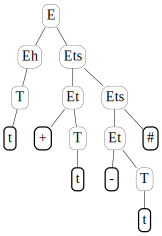

In [ ]:
# graficamente

ProductionGraph(Derivation(G).leftmost(steps))

## Generazione automatica del parser

Iniziamo con l'osservare che gli `if` della soluzione manuale sono prodotti, uno per ciascun simbolo, considerando in sequenza le possibili alternative (lati destri delle produzioni) e restituendo successo al primo tentativo valido.

Un esmepio è il simbolo `Ets` le cui due alternative sono `Et Ets` e `Et #`… supponiamo di scaricarne la soluzione a due funzioni denominate `Ets_alt0` e `Ets_alt0` che definiremo in seguito.

In [ ]:
def parse(X, rest):

  # ...

  if X == 'Ets':
    succ_alt, rest_alt = Ets_alt0(rest)
    if succ_alt: return True, rest_alt
    succ_alt, rest_alt = Ets_alt1(rest)
    if succ_alt: return True, rest_alt
    return False, rest

  # ...

Ciascuna alternativa e valutata considerando in sequenza i simboli di cui è costituita, vediamo ad esempio `Et Ets`

In [ ]:
def Ets_alt0(rest):
  succ, rest = parse('Et', rest)
  if not succ: return False, rest
  succ, rest = parse('Ets', rest)
  if not succ: return False, rest
  return True, rest

e similmente `Et #` 

In [ ]:
def Ets_alt1(rest):
    succ, rest = parse('Et', rest)
    if not succ: return False, rest
    succ, rest = parse('#', rest)
    if not succ: return False, rest
    return True, rest

Non è difficile scrivere una funzione che, data $G$ come input, produca il testo sorgente della funzione `parse` procedendo come sopra.

Ci servono due funzioni di utlità: la prima per indentare un blocco di testo al livello di intentazione specificato, la seconda per tradurre il codice sorgente di una funzione Python di nome `parse` in codice eseguibile.

In [ ]:
def indent_at(level, source):
  return indent(dedent(source), '  ' * level).strip('\n')

def make_parse(source):
  glb = {'show_calls': show_calls}
  exec(source, glb)
  return glb['parse']

Siamo pronti per procedere, useremo le [f-stringhe](https://docs.python.org/3/reference/lexical_analysis.html#f-strings) per maggior compattezza, scriviamo una funzione che data $G$ restituisca il sorgente di `parse` costruita secondo i criteri precedentemente espressi.

In [ ]:
def make_parse_source(G):

  # prima le definizioni delle funzioni A_altN

  defs = []
  for A in G.N:
    for n, α in enumerate(G.alternatives(A)):
      # la funzione "{A}_alt{n}"
      defs.append(f'def {A}_alt{n}(rest):')
      for X in α: 
        # una coppia di linee per ogni simbolo
        defs.append(indent_at(1, f'''
          succ, rest = parse('{X}', rest)
          if not succ: return False, rest
        '''))
      defs.append(indent_at(1,'return True, rest'))

  # poi gli if, uno per terminale

  ifs = []
  for A in G.N:
    # l'if "X == '{A}'"
    ifs.append(f"if X == '{A}':")
    for n, _ in enumerate(G.alternatives(A)): 
      # una coppia di linee, una per alternativa
      ifs.append(indent_at(1, f'''
        succ_alt, rest_alt = {A}_alt{n}(rest)
        if succ_alt: return True, rest_alt
      '''))
    ifs.append(indent_at(1,'return False, rest'))

  # in fine i terminali

  ifs.append(indent_at(0, f'''
    if X in {G.T}:
      if rest and rest[0] == X: return True, rest[1:]
      return False, rest
  '''))

  # e ora mettiamo tutto assieme 

  parse = '\n'.join((
    indent_at(0, '''
      @show_calls(True)
      def parse(X, rest):
    '''), 
    indent_at(1, '\n'.join(defs)), 
    indent_at(1, '\n'.join(ifs))
  ))

  return parse

Siamo pronti, generiamo (e stampiamo) il sorgente

In [ ]:
source = make_parse_source(G) # G è la grammatica prefix-free dell'inizio
print(source)

@show_calls(True)
def parse(X, rest):
  def E_alt0(rest):
    succ, rest = parse('Eh', rest)
    if not succ: return False, rest
    succ, rest = parse('Ets', rest)
    if not succ: return False, rest
    return True, rest
  def E_alt1(rest):
    succ, rest = parse('Eh', rest)
    if not succ: return False, rest
    succ, rest = parse('#', rest)
    if not succ: return False, rest
    return True, rest
  def T_alt0(rest):
    succ, rest = parse('t', rest)
    if not succ: return False, rest
    return True, rest
  def Ets_alt0(rest):
    succ, rest = parse('Et', rest)
    if not succ: return False, rest
    succ, rest = parse('Ets', rest)
    if not succ: return False, rest
    return True, rest
  def Ets_alt1(rest):
    succ, rest = parse('Et', rest)
    if not succ: return False, rest
    succ, rest = parse('#', rest)
    if not succ: return False, rest
    return True, rest
  def Et_alt0(rest):
    succ, rest = parse('+', rest)
    if not succ: return False, rest
    succ, rest = pa

E ora rendiamolo "eseguibile" e testiamolo sull'input

In [ ]:
parse = make_parse(source)

parse('E', 't+t-t#')

┌parse('E', 't+t-t#')
│┌parse('Eh', 't+t-t#')
││┌parse('T', 't+t-t#')
│││┌parse('t', 't+t-t#')
│││└─ (True, '+t-t#')
││└─ (True, '+t-t#')
│└─ (True, '+t-t#')
│┌parse('Ets', '+t-t#')
││┌parse('Et', '+t-t#')
│││┌parse('+', '+t-t#')
│││└─ (True, 't-t#')
│││┌parse('T', 't-t#')
││││┌parse('t', 't-t#')
││││└─ (True, '-t#')
│││└─ (True, '-t#')
││└─ (True, '-t#')
││┌parse('Ets', '-t#')
│││┌parse('Et', '-t#')
││││┌parse('+', '-t#')
││││└─ (False, '-t#')
││││┌parse('-', '-t#')
││││└─ (True, 't#')
││││┌parse('T', 't#')
│││││┌parse('t', 't#')
│││││└─ (True, '#')
││││└─ (True, '#')
│││└─ (True, '#')
│││┌parse('Ets', '#')
││││┌parse('Et', '#')
│││││┌parse('+', '#')
│││││└─ (False, '#')
│││││┌parse('-', '#')
│││││└─ (False, '#')
││││└─ (False, '#')
││││┌parse('Et', '#')
│││││┌parse('+', '#')
│││││└─ (False, '#')
│││││┌parse('-', '#')
│││││└─ (False, '#')
││││└─ (False, '#')
│││└─ (False, '#')
│││┌parse('Et', '-t#')
││││┌parse('+', '-t#')
││││└─ (False, '-t#')
││││┌parse('-', '-t#')
││││└─ (True, 't#'

(True, '')

## Un caso concreto non prefix-free

Cosa succede se $G$ non è *prefix-free*?

In [ ]:
# una grammatica non prefix-free (L = {a, ab})

G = Grammar.from_string("""
S -> a | a b
""")
G

Grammar(N={S}, T={a, b}, P=(S -> a, S -> a b), S=S)

In [ ]:
# costruiamo il parser e tentiamo il parse

source = make_parse_source(G)
parse = make_parse(source)
parse('S', 'ab')


┌parse('S', 'ab')
│┌parse('a', 'ab')
│└─ (True, 'b')
└─ (True, 'b')


(True, 'b')

Questo è un fallimento, non è stata considerata la seconda produzione ed in fatti è "avanzata" la `b`. Questo avviene perché il parser valuta in sequenza le alterniative e procede nella ricorsione al primo successo (non investigando se ci siano altri possibili successi in altre alternative).